______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*: 
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022
______________________________________



**Set Up**

In [519]:
# Importamos las liberias para los manejos de datos y graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.datasets import load_iris
from sklearn.neighbors import LocalOutlierFactor

from matplotlib.ticker import PercentFormatter
from google.colab import drive

# Establecemos conecciones necesarias para poder usar nuestra base
drive.mount('/content/drive')

# Accedemos al archivo a analizar
properati=pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021.csv')
# properati=pd.read_csv('properati_argentina_2021.csv')


import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  **1. Análisis Exploratorio y Preprocesamiento de Datos**

## **1a. Exploración Inicial**
A continuación se realizara un análisis general de cada una de las variables presentes en el dataframe.

In [520]:
df = properati.copy()
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Actualmente los únicos dos tipos de datos que tenemos son Float64 y Object.

Viendo las primeras entradas, podemos observar que el tipo Object oculta fechas que se adecuan mejor al tipo de datos DateTime.

In [521]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


### Preparación de los datasets

---



Aplicamos los filtros necesarios que figuran en los requerimientos, y cambiamos el dtype de las fechas a DateTime. 

Por otro lado, determinamos tanto el modelo a entrenar como el que usaremos para realizar las predicciones.

In [522]:
df = df.loc[df['property_type'].isin(["Casa", "PH", "Departamento"])].loc[df['place_l2'].isin(["Capital Federal"])].loc[df['operation'].isin(["Venta"])].loc[df['property_currency'].isin(["USD"])]
df['start_date']= pd.to_datetime(df['start_date'])
df['created_on']= pd.to_datetime(df['created_on'])
df.replace(to_replace="9999-12-31", value="", inplace=True)
df['end_date']= pd.to_datetime(df['end_date'])

train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)
df.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

### Descripción de Campos

---



`id`: Identificador del aviso

`start_date`: Fecha de alta del aviso

`end_date`: Fecha de baja del aviso

`created_on`: Fecha de alta de la primera versión del aviso

`latitud`: Ubicación geográfica

`longitud`: Ubicación geográfica

`place_l2`: Nivel administrativo 2, usualmente provincia

`place_l3`: Nivel administrativo 3, usualmente ciudad

`place_l4`: Nivel administrativo 4, usualmente barrio

`place_l5`: Nivel administrativo 5

`place_l6`: Nivel administrativo 6

`operation`: Tipo de operación (venta, alquiler)

`property_type`: Tipo de propiedad (casa, departamento, ph)

`property_rooms`: Cantidad de ambientes

`property_bedrooms`: Cantidad de dormitorios

`property_surface_total`: Superficie total en metros cuadrados

`property_surface_covered`: Superficie cubierta en metros cuadrados

`property_price`: Precio publicado en el anuncio

`property_currency`: Moneda del precio publicado

`property_title`: Título del anuncio

### Variables Cuantitativas: Medidas de Resumen

---



Calculamos, para la totalidad de las variables que nos brinda el dataset:
- media
- mediana
- q1
- q3 
- moda

In [523]:
df.describe().loc[['mean', '25%', '75%', 'std']].append(df.median().rename("median"))

,latitud,longitud,place_l5,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
mean,-34.591481,-58.449795,NaN,NaN,2.822799,2.014629,109.092970,87.931932,226238.207185
25%,-34.615975,-58.466522,NaN,NaN,2.000000,1.000000,45.000000,40.000000,95000.000000
75%,-34.577413,-58.408862,NaN,NaN,4.000000,3.000000,105.000000,88.000000,237000.000000
std,0.181719,0.292630,NaN,NaN,1.426148,1.129767,980.401976,990.927129,318603.483648
median,-34.595790,-58.439000,NaN,NaN,3.000000,2.000000,65.000000,58.000000,143900.000000


### Variables Cualitativas: Cantidades y Frecuencias


---


Realizamos, para las variables `place_l3`, `place_l4` y `property_type` un cálculo de los diferentes valores así también como sus respectivas frecuencias.

In [524]:
print(f"place_l3 tiene {df.nunique()['place_l3']} valores diferentes")

place_l3 tiene 57 valores diferentes


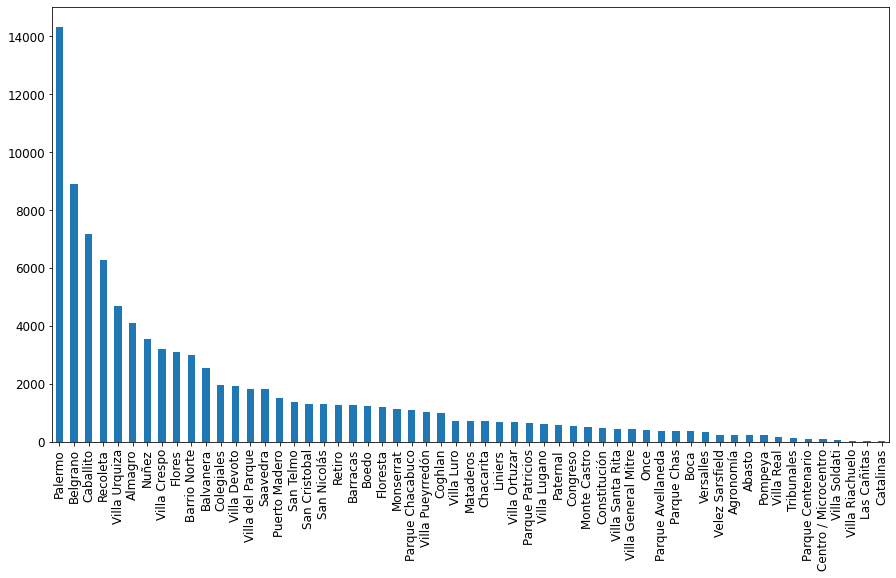

In [525]:
fig, ax = plt.subplots()
df['place_l3'].value_counts().plot(ax=ax, kind='bar', figsize=(15,8), fontsize=12)

In [526]:
print(f"place_l4 tiene {df.nunique()['place_l4']} valores diferentes")

place_l4 tiene 4 valores diferentes


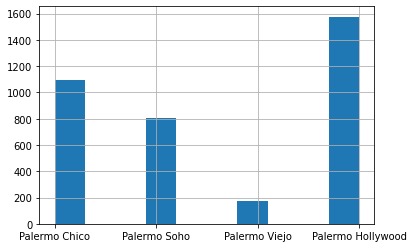

In [527]:
df['place_l4'].hist()

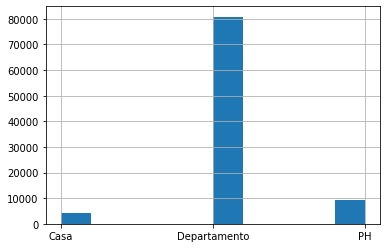

In [528]:
df['property_type'].hist()

In [529]:
print(f"property_type tiene {df.nunique()['property_type']} valores diferentes")

property_type tiene 3 valores diferentes


### Determinación de Variables Irrelevantes

---



Finalmente, podremos decir que dejamos fuera de este análisis particular a las a las siguientes variables que detallamos a continuación:

- `operation`: Sólo hay un tipo de operación según lo solicitado en la consigna y es "Venta", con lo cual la consideramos irrelevante en el análisis.
- `property_currency`: Sólo hay un tipo de cambio según lo solicitado en la consigna y es "USD", con lo cual la consideramos irrelevante en el análisis.
- `place_l5`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `place_l6`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `property_title`: De conocer previamente la información que contiene el dataset, sabemos que la variable en cuestión almacena un único título por publicación, con lo cual la consideramos irrelevante en el análisis.

### Análisis Gráfico de las Distribuciones de las Variables

---



##### Densidad de la variable `latitud`

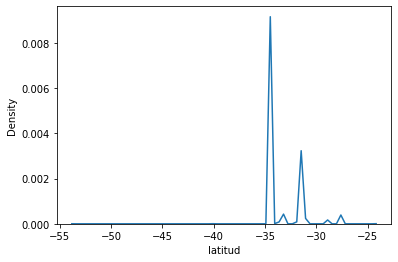

In [530]:
#grf = df['latitud'].plot.kde(title="Densidad variable Start date",xlabel="x",ylabel="y").xlim(-10, 10)
#sns.displot(df.latitud, hist=False, kde_kws={'clip': (-10.0, 10.0)})
# ver despues de machearlas con los property_types 
sns.kdeplot(data=df.latitud, gridsize=70)

##### Densidad de la variable `longitud`

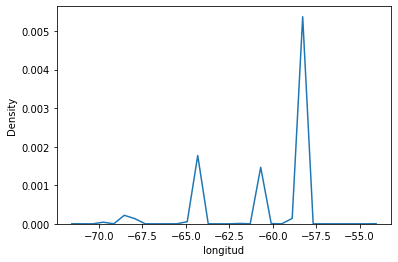

In [531]:
sns.kdeplot(data=df.longitud, gridsize=30)


##### Densidad de la variable `property_price`

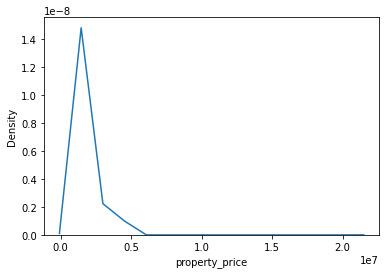

In [532]:
sns.kdeplot(data=df.property_price, gridsize=15)


##### Densidad de la variable `property_rooms`

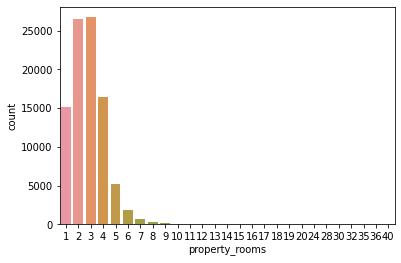

In [533]:
sns.countplot(x=df['property_rooms'].dropna().astype('int32'))

##### Densidad de la variable `property_surface_covered`

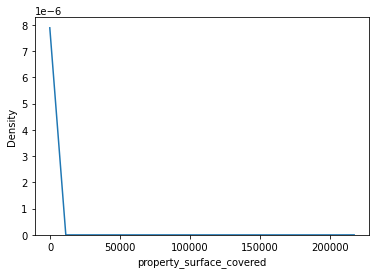

In [534]:
sns.kdeplot(data=df.property_surface_covered, gridsize=20)


### Análisis de las Correlaciones existentes entre las Variables

---



In [535]:
df.drop(["place_l5", "place_l6"], axis = 1, inplace = True)

In [536]:
#columns = df.columns.tolist()
#df_pariplot = df[columns].copy()
#graf_pairplot = sns.pairplot(data=df_pariplot, hue="property_type", palette=["r", "g", "b"])

## **1b. Datos Faltantes**
A continuación se realizara un análisis sobre los datos faltantes del dataframe.

### Análisis a Nivel Columna

---



Graficamos, para cada variable, el porcentaje (diferente de cero) de datos faltantes con respecto al total del dataset en escala logarítmica.

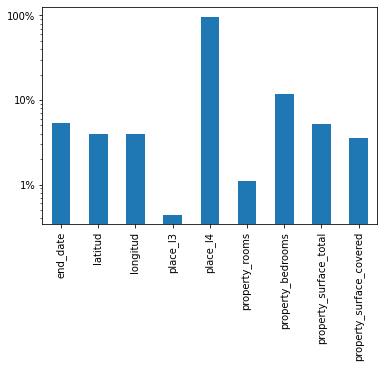

In [537]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

### Análisis a Nivel Fila

---



Graficamos el porcentaje de filas con n datos faltantes con respecto al total del dataset.

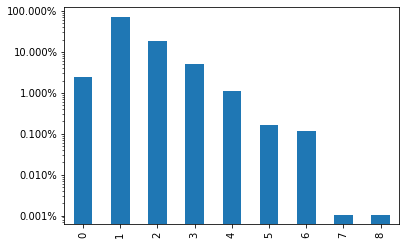

In [538]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=3))
(df.isnull().sum(axis=1).value_counts().sort_index() * 100 / len(df)).plot(ax=ax, kind='bar')

### Reparación de Valores Faltantes

---



A continuación se detallan posibles estrategias para reparar los valores faltantes del dataset.

Reemplazamos las locaciones no definidas por el nivel superior

In [539]:
df.place_l3.fillna(df.place_l2, inplace=True)
df.place_l4.fillna(df.place_l3, inplace=True)

Reemplazamos la cantidad de dormitorios no definidos por la media calculada filtrando por cantidad total de habitaciones.


In [540]:
cant = df.loc[(df['property_bedrooms'].isna()) & (df['property_rooms'].notna())].property_rooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_bedrooms'].notna()) & (df['property_rooms'] == i)].property_bedrooms.median()
    df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"] = df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"].fillna(median)


Luego reemplazamos la cantidad total de habitaciones no definidas por la media calculada filtrando por cantidad de dormitorios.

Esto redujo el porcentaje de valores no definidos para los dormitorios y habitaciones a menos de 1%, desde 10% y 1,5% respectivamente.

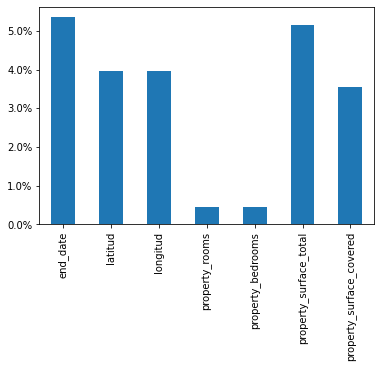

In [541]:
cant = df.loc[(df['property_rooms'].isna()) & (df['property_bedrooms'].notna())].property_bedrooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_rooms'].notna()) & (df['property_bedrooms'] == i)].property_rooms.median()
    df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"] = df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"].fillna(median)
    
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')


Cuando se tiene la superficie total pero no la cubierta o viceversa, reemplazamos los valores faltantes con su contraparte

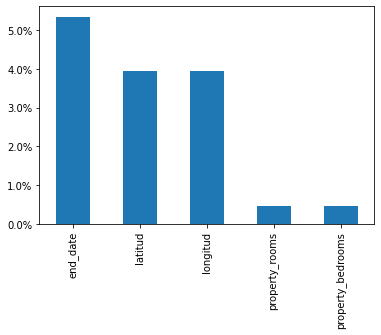

In [542]:
df.property_surface_total.fillna(df.property_surface_covered, inplace=True)
df.property_surface_covered.fillna(df.property_surface_total, inplace=True)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

## FALTA ARREGLAR LATITUD Y LONGITUD.

## **1c. Valores atípicos**

A continuación se realizara un análisis sobre los valores atípicos presentes en el dataframe. En la totalidad del dataset logramos detectar outliers tanto univariados (presentes en una unica variable) como multivariados (se encuentran en un espacio n-dimensional).

### Outliers univariados


---


Utilizando los gráficos de tipo Box-Plot vamos a intentar identificarlos:

#### Property rooms

##### Box plot

Como se puede observar en el siguiente grafico, tenemos una serie de valores atipicos referenciados a la cantidad de ambientes de las propiedades. Si tomamos en cuenta los extremos de los cuartiles que calculamos a continuacion, notamos que algunos quedan excesivamente altos en comparacion.

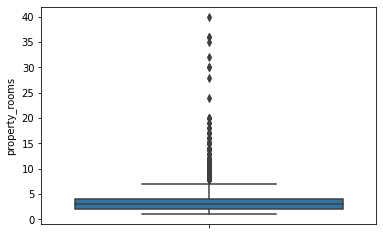

In [543]:
sns.boxplot(y=df.property_rooms)
plt.show()

In [544]:
# Cuartiles
Q1_property_rooms=df.describe().get("property_rooms").get("25%")
Q3_property_rooms=df.describe().get("property_rooms").get("75%")

print("El valor de Q1 es:", Q1_property_rooms)
print("El valor de Q3 es:", Q3_property_rooms)

# Rango intercuartil
IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

# Limites Outliers
out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 2.0
El valor de Q3 es: 4.0
El limite inferior del Q1 es: -1.0
El limite superior del Q3 es: 7.0


Confirmamos que tratamos con un outlier notando la relacion por ejemplo con la variable property rooms

In [545]:
outlier=df[df['property_rooms']>7]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09,2021-09-09,-34.586193,-58.396815,Capital Federal,Recoleta,Recoleta,Venta,Departamento,9.0,4.0,390.0,340.0,1200000.0,USD,“La Isla”-Gelly Obes-Copérnico-Espectacular pi...
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Luro,Villa Luro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Monte Castro,Monte Castro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459706,rhZ7e0ygquCQbMZX+WCIcA==,2021-01-05,2021-02-03,2021-01-05,NaN,NaN,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,256.0,256.0,800000.0,USD,Excelente departamento con cochera en venta en...
459724,ZHK1Il6hnxI3iMhjvmD5+g==,2021-01-05,2021-10-16,2021-01-05,-34.587991,-58.389017,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,3.0,285.0,272.0,1250000.0,USD,Departamento de excelente categoria en venta e...
459755,oFcI5JAbOEsVvsk6PhM6fg==,2021-01-05,2022-06-12,2021-01-05,-34.590653,-58.384325,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,431.0,415.0,2800000.0,USD,Departamento de excelente calidad con 5 dormit...
459764,oX3aPs/sStr80cOS+VyxVw==,2021-01-05,NaT,2021-01-05,-34.586441,-58.387889,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,4.0,383.0,383.0,1700000.0,USD,Departamento frances con 2 cocheras en venta e...


In [546]:
outlier=df[df['property_rooms']<1]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title


In [547]:
#Eliminación de outlier por ínidce de fila
#indice_outlier=df[df['property_rooms']>7].index
#df.drop(df[df['property_rooms']>7].index, inplace=True)

#indice_outlier=df[df['property_rooms']<1].index
#df.drop(df[df['property_rooms']<1].index, inplace=True)

#sns.boxplot(y=df.property_rooms)
#plt.show()

##### Z-Score
Comprobamos ahora los outliers que obtenemos utilizando el metodo Z-Score



In [548]:
media_rooms=np.mean(df.property_rooms)
std_rooms=np.std(df.property_rooms)
df['z_rooms']=(df.property_rooms - media_rooms)/std_rooms

In [549]:
df[df['z_rooms']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09,2021-09-09,-34.586193,-58.396815,Capital Federal,Recoleta,Recoleta,Venta,Departamento,9.0,4.0,390.0,340.0,1200000.0,USD,“La Isla”-Gelly Obes-Copérnico-Espectacular pi...,4.296317
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Luro,Villa Luro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Monte Castro,Monte Castro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459706,rhZ7e0ygquCQbMZX+WCIcA==,2021-01-05,2021-02-03,2021-01-05,NaN,NaN,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,256.0,256.0,800000.0,USD,Excelente departamento con cochera en venta en...,3.599764
459724,ZHK1Il6hnxI3iMhjvmD5+g==,2021-01-05,2021-10-16,2021-01-05,-34.587991,-58.389017,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,3.0,285.0,272.0,1250000.0,USD,Departamento de excelente categoria en venta e...,3.599764
459755,oFcI5JAbOEsVvsk6PhM6fg==,2021-01-05,2022-06-12,2021-01-05,-34.590653,-58.384325,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,431.0,415.0,2800000.0,USD,Departamento de excelente calidad con 5 dormit...,3.599764
459764,oX3aPs/sStr80cOS+VyxVw==,2021-01-05,NaT,2021-01-05,-34.586441,-58.387889,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,4.0,383.0,383.0,1700000.0,USD,Departamento frances con 2 cocheras en venta e...,3.599764


In [550]:
df[df['z_rooms']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms


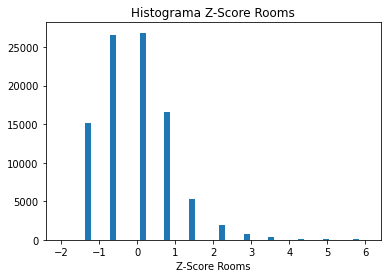

In [551]:
plt.hist(df.z_rooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Rooms')
plt.xlabel('Z-Score Rooms')
plt.show()

##### Z-Score Modificado
Verificamos una vez mas utilizando la modificacion de este ultimo metodo

In [552]:
mediana_room=np.median(df.property_rooms)

MAD=np.median(np.absolute(df.property_rooms-mediana_room))

df['zm_rooms']=(df.property_rooms - mediana_room)*0.6745/MAD

In [553]:
df[(df['zm_rooms']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms


In [554]:
df[(df['zm_rooms']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms


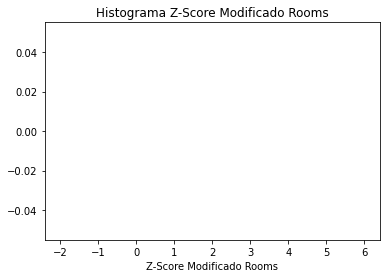

In [555]:
plt.hist(df.zm_rooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Rooms')
plt.xlabel('Z-Score Modificado Rooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones que superan el límite superior del tercer cuartil, podríamos decir que los outliers en cuestión son del tipo colectivo.

#### Property bedrooms

Al igual que los ambientes, podemos notar tambien aca la presencia de algunos valores lejanos a los extremos de los cuartiles que usamos de referencia. En particular tenemos uno notoriamente distanciado cercano al numero 70.

Repetimos los metodos anteriores.

 ##### Box plot


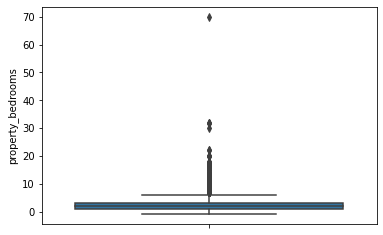

In [556]:
sns.boxplot(y=df.property_bedrooms)
plt.show()

In [557]:
# Cuartiles
Q1_property_bedrooms=df.describe().get("property_bedrooms").get("25%")
Q3_property_bedrooms=df.describe().get("property_bedrooms").get("75%")

print("El valor de Q1 es:", Q1_property_bedrooms)
print("El valor de Q3 es:", Q3_property_bedrooms)

# Rango intercuartil
IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

# Limites Outliers
out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 1.0
El valor de Q3 es: 3.0
El limite inferior del Q1 es: -2.0
El limite superior del Q3 es: 6.0


Confirmamos que tratamos con un outlier notando la relacion por ejemplo con la variable property rooms

In [558]:
outlier=df[df['property_bedrooms']>6]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,NaN
1800,xOxObQG9UHaTxLPYGOtK4w==,2021-12-17,2022-02-09,2021-12-17,-34.616128,-58.394715,Capital Federal,Balvanera,Balvanera,Venta,Casa,8.0,7.0,164.0,143.0,215000.0,USD,Casa 8 Ambientes ubicada en Balvanera,3.599764,NaN
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01,2021-02-20,-34.623590,-58.401566,Capital Federal,San Cristobal,San Cristobal,Venta,PH,15.0,15.0,355.0,215.0,220000.0,USD,PH 15 AMBIENTES HOTEL A RECICLAR San Cristóbal,8.475638,NaN
6355,PZJRORTIAvMTvI3A+FLDUQ==,2021-10-29,2021-11-03,2021-10-29,-34.577180,-58.451264,Capital Federal,Colegiales,Colegiales,Venta,Departamento,6.0,8.0,424.0,324.0,660000.0,USD,DEPARTAMENTOS CON 2 UNIDADES COMPLEMENTARIAS E...,2.206657,NaN
6869,vtFpL0vRYrdtMyLuHCrhkQ==,2021-02-09,NaT,2021-02-09,-34.631952,-58.373878,Capital Federal,Barracas,Barracas,Venta,Casa,8.0,7.0,350.0,350.0,550000.0,USD,EXCELENTE CASA EN TERRENO PROPIO,3.599764,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451439,xAhwsSTSgi3S3LwevVCiLA==,2021-12-16,2021-12-21,2021-12-16,-34.609154,-58.383631,Capital Federal,Congreso,Congreso,Venta,Departamento,10.0,9.0,240.0,227.0,370000.0,USD,Venta 10 amb - Congreso - Edificio Historico A...,4.992871,NaN
457063,D2v8pvBdj56lpVuQPiSbQA==,2021-05-08,2021-05-20,2021-05-08,-34.572554,-58.469842,Capital Federal,Belgrano,Belgrano,Venta,Casa,8.0,7.0,400.0,400.0,920000.0,USD,Casa - Belgrano R - Esquina,3.599764,NaN
457064,rWpwKlxzNHvQYcrs+sBijQ==,2021-05-08,2021-05-20,2021-05-08,-34.572554,-58.469842,Capital Federal,Belgrano,Belgrano,Venta,Casa,8.0,7.0,400.0,400.0,920000.0,USD,Casa - Belgrano R - Lote propio - Esquina - Oc...,3.599764,NaN
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,NaT,2021-01-05,-34.625353,-58.372014,Capital Federal,San Telmo,San Telmo,Venta,Casa,12.0,12.0,820.0,820.0,550000.0,USD,Casa de 820 m2 en San Telmo,6.385977,NaN


##### Z-Score

In [559]:
media_bedrooms=np.mean(df.property_bedrooms)
std_bedrooms=np.std(df.property_bedrooms)
df['z_bedrooms']=(df.property_bedrooms - media_bedrooms)/std_bedrooms

In [560]:
df[df['z_bedrooms']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,NaN,7.237343
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Luro,Villa Luro,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,NaN,3.657724
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Monte Castro,Monte Castro,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,NaN,3.657724
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,NaN,3.657724
1363,rfG2Nb7079oZOP8wAKuwXA==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Santa Rita,Villa Santa Rita,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,NaN,3.657724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457366,addYhPIIGDmKeww0LFYSTg==,2021-05-08,2021-06-05,2021-05-08,-34.631404,-58.403266,Capital Federal,Parque Patricios,Parque Patricios,Venta,...,7.0,6.0,280.0,230.0,426000.0,USD,Casa - Parque Patricios,2.903210,NaN,3.657724
457782,zThHFYUg/ZODnN9ekjwgFg==,2021-05-08,2021-06-05,2021-05-08,-34.581524,-58.403588,Capital Federal,Palermo,Palermo,Venta,...,10.0,6.0,520.0,500.0,3300000.0,USD,Venta Departamento Palermo,4.992871,NaN,3.657724
458670,naEatqtTCG8ALXICib4ZxQ==,2021-01-05,2022-08-12,2021-01-05,-34.577390,-58.475421,Capital Federal,Villa Urquiza,Villa Urquiza,Venta,...,5.0,6.0,125.0,100.0,265000.0,USD,Alvarez Thomas 2400 Exc PH SIN EXPENSAS- 5 am...,1.510104,NaN,3.657724
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,NaT,2021-01-05,-34.625353,-58.372014,Capital Federal,San Telmo,San Telmo,Venta,...,12.0,12.0,820.0,820.0,550000.0,USD,Casa de 820 m2 en San Telmo,6.385977,NaN,9.027152


In [561]:
df[df['z_bedrooms']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms


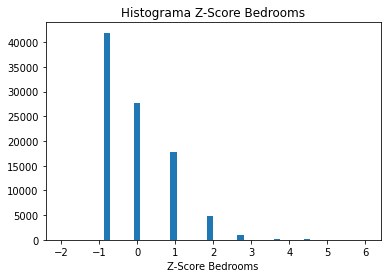

In [562]:
plt.hist(df.z_bedrooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Bedrooms')
plt.xlabel('Z-Score Bedrooms')
plt.show()

##### Z-Score Modificado

In [563]:
mediana_bedroom=np.median(df.property_bedrooms)
MAD=np.median(np.absolute(df.property_bedrooms-mediana_bedroom))

df['zm_bedrooms']=(df.property_bedrooms - mediana_bedroom)*0.6745/MAD

In [564]:
df[(df['zm_bedrooms']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms


In [565]:
df[(df['zm_bedrooms']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms


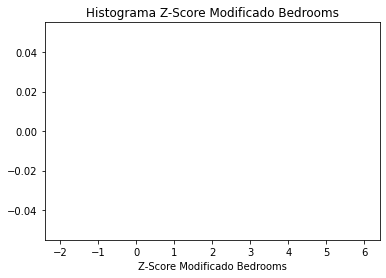

In [566]:
plt.hist(df.zm_bedrooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Bedrooms')
plt.xlabel('Z-Score Modificado Bedrooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la singular por encima del resto de las observaciones).

#### Property price

##### Box plot

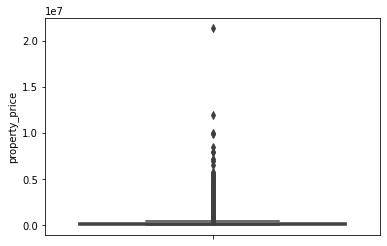

In [567]:
sns.boxplot(y=df.property_price)
plt.show()

In [568]:
# Cuartiles
Q1_property_price=df.describe().get("property_price").get("25%")
Q3_property_price=df.describe().get("property_price").get("75%")

print("El valor de Q1 es:", Q1_property_price)
print("El valor de Q3 es:", Q3_property_price)

# Rango intercuartil
IQR_property_price=Q3_property_price-Q1_property_price

# Limites Outliers
out_inf=Q1_property_price-1.5*IQR_property_price
out_sup=Q3_property_price+1.5*IQR_property_price
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 95000.0
El valor de Q3 es: 237000.0
El limite inferior del Q1 es: -118000.0
El limite superior del Q3 es: 450000.0


Confirmamos que tratamos con un outlier

In [569]:
outlier=df[df['property_price']>450000]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,NaN,7.237343,NaN
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,4.0,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,NaN,1.867914,NaN
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,4.0,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,NaN,1.867914,NaN
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,3.0,282.0,256.0,2250000.0,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,NaN,0.973010,NaN
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,4.0,304.0,294.0,1200000.0,USD,Departamento de 5 ambientes con dependencia -...,1.510104,NaN,1.867914,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459868,flZJmrO8SSTHv+d+AoanUw==,2021-01-05,2021-04-20,2021-01-05,-34.626835,-58.372299,Capital Federal,San Telmo,San Telmo,Venta,...,2.0,174.0,155.0,530000.0,USD,La esquina mas linda de San Telmo en venta,1.510104,NaN,0.078105,NaN
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,NaT,2021-01-05,-34.613000,-58.362117,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,2.0,176.0,163.0,790000.0,USD,Departamento en venta en Puerto Madero,0.116997,NaN,0.078105,NaN
459997,q3Im3Bm7Mi9ufVUH5rjWxw==,2021-01-05,2021-06-05,2021-01-05,-34.618084,-58.359912,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,2.0,315.0,180.0,2200000.0,USD,Venta Departamento Pent House 4 Ambientes Pil...,0.813550,NaN,0.078105,NaN
460002,w+3qsITCAFukJ0S15B8znQ==,2021-01-05,2021-07-07,2021-01-05,-34.618595,-58.361978,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,1.0,68.0,56.0,520000.0,USD,Excelente Suite en Hotel SLS Puerto Madero | 2...,-0.579557,NaN,-0.816800,NaN


##### Z-Score

In [570]:
media_price=np.mean(df.property_price)
std_price=np.std(df.property_price)
df['z_price']=(df.property_price - media_price)/std_price

In [571]:
df[df['z_price']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,NaN,1.867914,NaN,7.764431
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,NaN,1.867914,NaN,7.764431
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,282.0,256.0,2250000.0,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,NaN,0.973010,NaN,6.352010
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,304.0,294.0,1200000.0,USD,Departamento de 5 ambientes con dependencia -...,1.510104,NaN,1.867914,NaN,3.056360
629,1Q/fC60k0cGKYTu6hUqf1g==,2021-09-09,2021-09-11,2021-09-09,-34.566536,-58.448246,Capital Federal,Belgrano,Belgrano,Venta,...,214.0,196.0,1200000.0,USD,Departamento - Belgrano,0.813550,NaN,0.973010,NaN,3.056360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459724,ZHK1Il6hnxI3iMhjvmD5+g==,2021-01-05,2021-10-16,2021-01-05,-34.587991,-58.389017,Capital Federal,Recoleta,Recoleta,Venta,...,285.0,272.0,1250000.0,USD,Departamento de excelente categoria en venta e...,3.599764,NaN,0.973010,NaN,3.213296
459729,gMY0XZIwhoegKoroHdxyrw==,2021-01-05,2022-09-15,2021-01-05,-34.587588,-58.389527,Capital Federal,Recoleta,Recoleta,Venta,...,271.0,265.0,1250000.0,USD,Departamento - Recoleta,2.206657,NaN,0.973010,NaN,3.213296
459755,oFcI5JAbOEsVvsk6PhM6fg==,2021-01-05,2022-06-12,2021-01-05,-34.590653,-58.384325,Capital Federal,Recoleta,Recoleta,Venta,...,431.0,415.0,2800000.0,USD,Departamento de excelente calidad con 5 dormit...,3.599764,NaN,2.762819,NaN,8.078303
459764,oX3aPs/sStr80cOS+VyxVw==,2021-01-05,NaT,2021-01-05,-34.586441,-58.387889,Capital Federal,Recoleta,Recoleta,Venta,...,383.0,383.0,1700000.0,USD,Departamento frances con 2 cocheras en venta e...,3.599764,NaN,1.867914,NaN,4.625717


In [572]:
df[df['z_price']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price


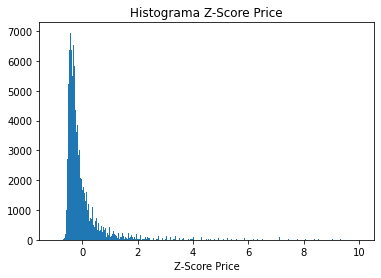

In [573]:
plt.hist(df.z_price, bins=300, range=(-1,10))
plt.title('Histograma Z-Score Price')
plt.xlabel('Z-Score Price')
plt.show()

##### Z-Score Modificado

In [574]:
mediana_price=np.median(df.property_price)
MAD=np.median(np.absolute(df.property_price-mediana_price))

df['zm_price']=(df.property_price - mediana_price)*0.6745/MAD

In [575]:
df[(df['zm_price']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,NaN,7.237343,NaN,0.859260,4.141197
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,NaN,1.867914,NaN,7.764431,29.725680
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,NaN,1.867914,NaN,7.764431,29.725680
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,256.0,2250000.0,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,NaN,0.973010,NaN,6.352010,24.492491
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,294.0,1200000.0,USD,Departamento de 5 ambientes con dependencia -...,1.510104,NaN,1.867914,NaN,3.056360,12.281715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,NaT,2021-01-05,-34.613000,-58.362117,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,163.0,790000.0,USD,Departamento en venta en Puerto Madero,0.116997,NaN,0.078105,NaN,1.769487,7.513697
459997,q3Im3Bm7Mi9ufVUH5rjWxw==,2021-01-05,2021-06-05,2021-01-05,-34.618084,-58.359912,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,180.0,2200000.0,USD,Venta Departamento Pent House 4 Ambientes Pil...,0.813550,NaN,0.078105,NaN,6.195074,23.911025
460002,w+3qsITCAFukJ0S15B8znQ==,2021-01-05,2021-07-07,2021-01-05,-34.618595,-58.361978,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,56.0,520000.0,USD,Excelente Suite en Hotel SLS Puerto Madero | 2...,-0.579557,NaN,-0.816800,NaN,0.922034,4.373784
460005,U2WS7omU6g9aUPRuyLt+IA==,2021-01-05,2022-06-02,2021-01-05,-34.614730,-58.361755,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,86.0,450000.0,USD,Departamento en venta en el Porteño Building,-0.579557,NaN,-0.816800,NaN,0.702324,3.559732


In [576]:
df[(df['zm_price']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price


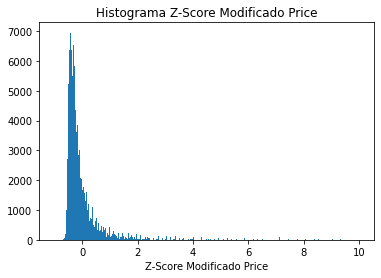

In [577]:
plt.hist(df.z_price, bins=300, range=(-1,10))
plt.title('Histograma Z-Score Modificado Price')
plt.xlabel('Z-Score Modificado Price')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

### Outliers multivariados


---


A continuacion vamos a analizar la presencia de outliers utilizando el metodo de Mahalanobis. 







Analizamos la presencia de valores nan en nuestro dataset.


In [578]:
mahal = df.copy()
mahal.isnull().sum()

id                              0
start_date                      0
end_date                     5041
created_on                      0
latitud                      3730
longitud                     3730
place_l2                        0
place_l3                        0
place_l4                        0
operation                       0
property_type                   0
property_rooms                432
property_bedrooms             433
property_surface_total          0
property_surface_covered        0
property_price                  0
property_currency               0
property_title                  0
z_rooms                       432
zm_rooms                    94249
z_bedrooms                    433
zm_bedrooms                 94249
z_price                         0
zm_price                        0
dtype: int64

Procedemos a eliminar los registros en cuestion dado que representan una pequeña porcion del dataset y no se veran afectados los resultados.

In [579]:
mahal.dropna(subset=['property_rooms', 'property_bedrooms'], inplace = True)
mahal.isnull().sum()

id                              0
start_date                      0
end_date                     5005
created_on                      0
latitud                      3666
longitud                     3666
place_l2                        0
place_l3                        0
place_l4                        0
operation                       0
property_type                   0
property_rooms                  0
property_bedrooms               0
property_surface_total          0
property_surface_covered        0
property_price                  0
property_currency               0
property_title                  0
z_rooms                         0
zm_rooms                    93816
z_bedrooms                      0
zm_bedrooms                 93816
z_price                         0
zm_price                        0
dtype: int64

#### Property surface total vs Price



##### Scatter


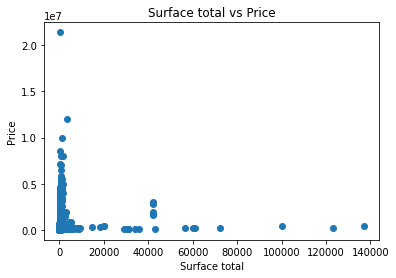

In [580]:
plt.scatter(mahal.property_surface_total,mahal.property_price)
plt.title('Surface total vs Price')
plt.xlabel('Surface total')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [581]:
X = mahal[['property_surface_total','property_price']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_sfto_prc'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,mahal_sfto_prc
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,Capital Federal,Capital Federal,Venta,...,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0.813550,NaN,0.973010,NaN,-0.050967,0.768697,0.005305
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,82900.0,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0.116997,NaN,0.078105,NaN,-0.449898,-0.709388,0.217700
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,99000.0,USD,Departamento - 4 Ambientes - Catalinas Sur,0.813550,NaN,0.973010,NaN,-0.399364,-0.522156,0.171884
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,146000.0,USD,Venta departamento 4 ambientes Once,0.813550,NaN,0.078105,NaN,-0.251845,0.024422,0.069293
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,250000.0,USD,PH - Boedo,0.813550,NaN,0.078105,NaN,0.074581,1.233870,0.006425


In [582]:
np.sort(mahal.mahal_sfto_prc) # Ordenamos distancias calculadas de menor a mayor

array([7.23992909e-07, 2.33021977e-06, 2.33021977e-06, ...,
       5.99886743e+03, 9.07527749e+03, 1.12538243e+04])

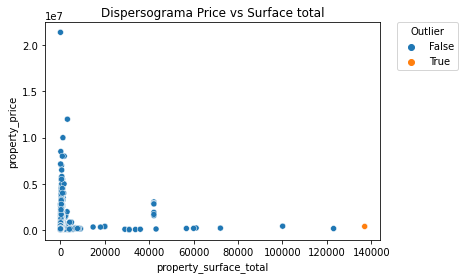

In [583]:
umbral=10000
mahal[mahal['mahal_sfto_prc']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_sfto_prc'] > umbral)

sns.scatterplot(x=mahal.property_surface_total,y=mahal.property_price, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Price vs Surface total')
plt.show()

##### Caracteristicas

Como podemos apreciar en el grafico, la mayor concentracion se presenta en la esquina inferior izquierda, aunque presenta algunos valores dispersos en las cercanias de ambos extremos. Por otro lado hay dos valores particularmente alejados. Siguiendo esta linea, llegamos a la conclusion de que estamos en presencia de outliers globales dada esta particularidad.

#### Property rooms vs Property bedrooms

##### Scatter

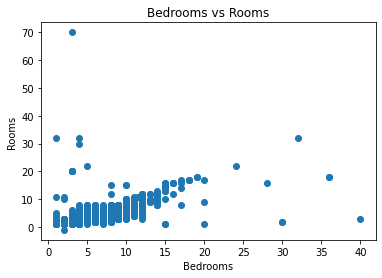

In [584]:
plt.scatter(mahal.property_rooms,mahal.property_bedrooms)
plt.title('Bedrooms vs Rooms')
plt.xlabel('Bedrooms')
plt.ylabel('Rooms')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [585]:
X = mahal[['property_rooms','property_bedrooms']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_bdro'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,mahal_sfto_prc,mahal_ro_bdro
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,Capital Federal,Capital Federal,Venta,...,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0.813550,NaN,0.973010,NaN,-0.050967,0.768697,0.005305,1.109393
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,USD,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0.116997,NaN,0.078105,NaN,-0.449898,-0.709388,0.217700,0.017579
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,USD,Departamento - 4 Ambientes - Catalinas Sur,0.813550,NaN,0.973010,NaN,-0.399364,-0.522156,0.171884,1.109393
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,USD,Venta departamento 4 ambientes Once,0.813550,NaN,0.078105,NaN,-0.251845,0.024422,0.069293,2.644373
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,USD,PH - Boedo,0.813550,NaN,0.078105,NaN,0.074581,1.233870,0.006425,2.644373


In [586]:
np.sort(mahal.mahal_ro_bdro) # Ordenamos distancias calculadas de menor a mayor

array([1.75787724e-02, 1.75787724e-02, 1.75787724e-02, ...,
       3.54125617e+03, 4.04084084e+03, 1.90405688e+04])

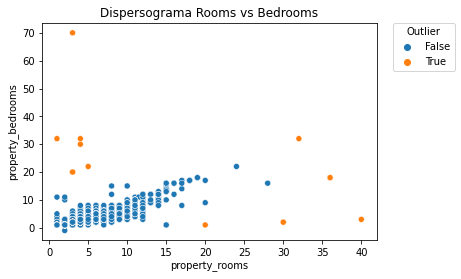

In [587]:
umbral=700
mahal[mahal['mahal_ro_bdro']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_bdro'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_bedrooms, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Bedrooms')
plt.show()

##### Caracteristicas

Como podemos apreciar en el grafico, la mayor concentracion nuevamente se presenta en la esquina inferior izquierda. Ademas de esto, notamos que estamos en presencia de outliers en su mayoria globales, con la particularidad de que tenemos algunos casos de outliers colectivos en las cercanias del rango 30 respecto del eje property_bedrooms.

Por otro lado hay dos valores particularmente alejados. Siguiendo esta linea, llegamos a la conclusion de que estamos en presencia de outliers globales dada esta particularidad.

#### Property rooms vs Property surface total

##### Scatter


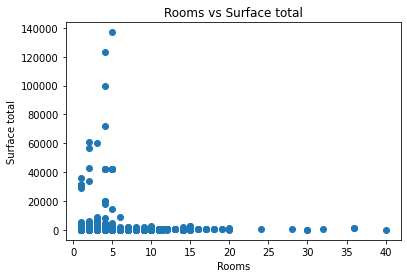

In [588]:
plt.scatter(mahal.property_rooms,mahal.property_surface_total)
plt.title('Rooms vs Surface total')
plt.xlabel('Rooms')
plt.ylabel('Surface total')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [589]:
X = mahal[['property_rooms','property_surface_total']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_sfto'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,Capital Federal,Capital Federal,Venta,...,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA,0.813550,NaN,0.973010,NaN,-0.050967,0.768697,0.005305,1.109393,0.713425
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,VENTA TRES AMBIENTES LA BOCA PISO ALTO,0.116997,NaN,0.078105,NaN,-0.449898,-0.709388,0.217700,0.017579,0.022559
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,Departamento - 4 Ambientes - Catalinas Sur,0.813550,NaN,0.973010,NaN,-0.399364,-0.522156,0.171884,1.109393,0.725401
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,Venta departamento 4 ambientes Once,0.813550,NaN,0.078105,NaN,-0.251845,0.024422,0.069293,2.644373,0.718611
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,PH - Boedo,0.813550,NaN,0.078105,NaN,0.074581,1.233870,0.006425,2.644373,0.724689


In [590]:
np.sort(mahal.mahal_ro_sfto) # Ordenamos distancias calculadas de menor a mayor

array([1.79546936e-02, 1.79546936e-02, 1.79546936e-02, ...,
       1.20863177e+04, 1.82717339e+04, 2.26592928e+04])

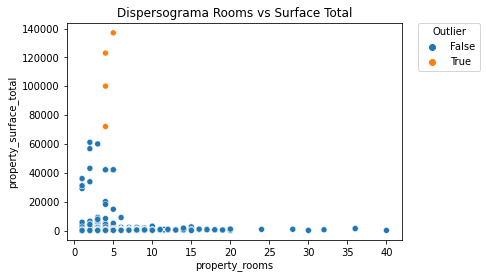

In [591]:
umbral=5000
mahal[mahal['mahal_ro_sfto']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_sfto'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_total, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Total')
plt.show()

##### Caracteristicas

En esta nueva comparacion, tenemos una vez mas, la mayor concentracion de observaciones en la esquina inferior izquierda. A su vez contamos con la presencia de registros aislados en la parte superior izquierda (outliers globales).

#### Property rooms vs Property surface covered

##### Scatter

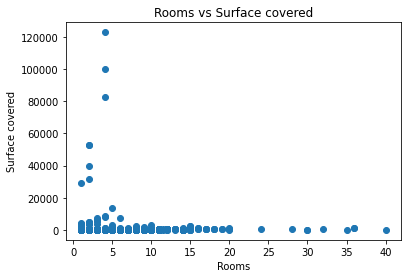

In [592]:
plt.scatter(df.property_rooms,df.property_surface_covered)
plt.title('Rooms vs Surface covered')
plt.xlabel('Rooms')
plt.ylabel('Surface covered')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [593]:
X = mahal[['property_rooms','property_surface_covered']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_sfcv'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto,mahal_ro_sfcv
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,Capital Federal,Capital Federal,Venta,...,0.813550,NaN,0.973010,NaN,-0.050967,0.768697,0.005305,1.109393,0.713425,0.649221
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,0.116997,NaN,0.078105,NaN,-0.449898,-0.709388,0.217700,0.017579,0.022559,0.090193
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,0.813550,NaN,0.973010,NaN,-0.399364,-0.522156,0.171884,1.109393,0.725401,0.873252
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,0.813550,NaN,0.078105,NaN,-0.251845,0.024422,0.069293,2.644373,0.718611,0.677340
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,0.813550,NaN,0.078105,NaN,0.074581,1.233870,0.006425,2.644373,0.724689,0.848891


In [594]:
np.sort(mahal.mahal_ro_sfcv) # Ordenamos distancias calculadas de menor a mayor

array([1.18905615e-02, 1.18905615e-02, 1.18905615e-02, ...,
       5.22481010e+05, 7.59591401e+05, 1.14854962e+06])

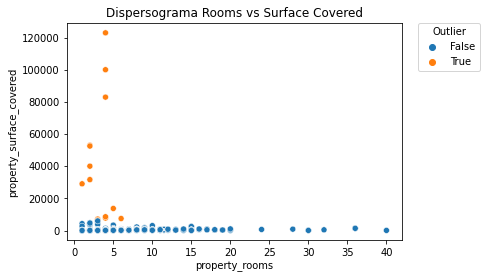

In [595]:
umbral=3000
mahal[mahal['mahal_ro_sfcv']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_sfcv'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_covered, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Covered')
plt.show()

##### Caracteristicas

Luego de la comparacion de surface covered vs property rooms, notamos que nuevamente estamos en presencia de outliers, en particular esta vez todos de caracter global.


#### Property rooms vs Property price

##### Scatter

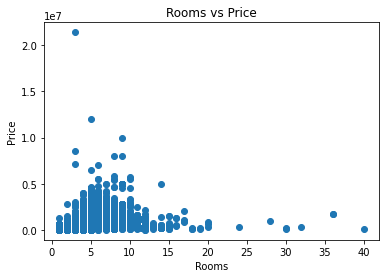

In [596]:
plt.scatter(mahal.property_rooms,mahal.property_price)
plt.title('Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [597]:
X = mahal[['property_rooms','property_price']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_pr'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto,mahal_ro_sfcv,mahal_ro_pr
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,Capital Federal,Capital Federal,Venta,...,NaN,0.973010,NaN,-0.050967,0.768697,0.005305,1.109393,0.713425,0.649221,1.052202
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,NaN,0.078105,NaN,-0.449898,-0.709388,0.217700,0.017579,0.022559,0.090193,0.400493
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,NaN,0.973010,NaN,-0.399364,-0.522156,0.171884,1.109393,0.725401,0.873252,1.696339
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,NaN,0.078105,NaN,-0.251845,0.024422,0.069293,2.644373,0.718611,0.677340,1.381461
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,NaN,0.078105,NaN,0.074581,1.233870,0.006425,2.644373,0.724689,0.848891,0.904687


In [598]:
np.sort(mahal.mahal_ro_pr) # Ordenamos distancias calculadas de menor a mayor

array([1.81131416e-02, 1.81131416e-02, 1.81131416e-02, ...,
       1.17237596e+03, 1.86300924e+03, 6.26708801e+03])

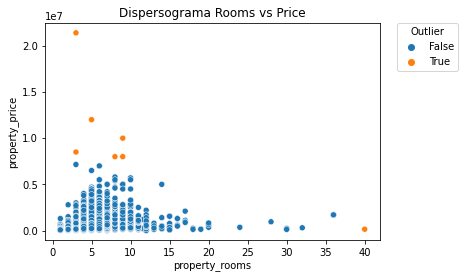

In [599]:
umbral=700
mahal[mahal['mahal_ro_pr']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_pr'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_price, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Price')
plt.show()

##### Caracteristicas

Nuevamente visualizamos outliers globales.

### Tratamiento

#  **2. Agrupamiento**

#  **3. Clasificación**

#  **4. Regresión**

#  **5. Conclusiones**